# Per Node Permutation


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv

from scipy.stats import loguniform, lognorm
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

from tqdm.notebook import tqdm

from joblib import Parallel, delayed

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

data_df = None
if os.path.isfile("data/data.pkl"):
    data_df = pd.read_pickle("data/data.pkl")
else:
    pass
data_df.head()

RANDOM_STATE = 42

In [2]:
# Definitions
# Define X and Y
ad_hc_df = data_df[
    data_df["Diagnosis"].isin(["AD", "HC"]) & (data_df["Harmonized"].notna())
].copy()
tbi_df = data_df[
    data_df["Diagnosis"].isin(["NEG", "POS"]) & (data_df["Harmonized"].notna())
].copy()

X_ad_hc = np.vstack(ad_hc_df["EVC"].values)
X_tbi = np.vstack(tbi_df["EVC"].values)

y_ad_hc = ad_hc_df["Diagnosis"].map({"AD": 1, "HC": 0}).values
y_tbi = tbi_df["Diagnosis"].map({"POS": 1, "NEG": 0}).values

# Ensure X is standard scaled to start
X_ad_hc = StandardScaler().fit_transform(X_ad_hc)
X_tbi = StandardScaler().fit_transform(X_tbi)

SPECIFIC_NODES = [2, 7, 83, 86, 120, 167]
#SPECIFIC_NODES = list(range(X_ad_hc.shape[1]))

# Model Definitions
# clf = NuSVC(
#     probability=True,
#     random_state=RANDOM_STATE,
#     cache_size=2000,
#     class_weight="balanced"
# )
clf = LinearSVC(
    penalty="l2",
    class_weight='balanced',
    random_state=RANDOM_STATE,
    verbose=1,
    max_iter=10000
)

svc_params = {
    "C": loguniform(10**-4, 10**4),
}

use_grid_search = True
gridsearch = RandomizedSearchCV(
    estimator=clf,
    param_distributions=svc_params,
    n_iter=1000,
    cv=LeaveOneOut(),
    refit=True,
    verbose=3,
    n_jobs=-1,
    error_score='raise',
    random_state=RANDOM_STATE,
    return_train_score=True
)

def loocv_classification(mdl, X, y):
    loo = LeaveOneOut()
    y_true, y_pred = [], []

    for train_index, test_index in loo.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf = clone(mdl)
        clf.fit(X_train, y_train)

        y_pred.append(clf.predict(X_test))
        y_true.append(y_test)

    return accuracy_score(y_true, y_pred), y_pred

In [3]:
# Obtain a model for AD/HC
if use_grid_search:
    gridsearch.fit(X_ad_hc[:, SPECIFIC_NODES], y_ad_hc)
    best_model_ad = gridsearch.best_estimator_
    pd.DataFrame(gridsearch.cv_results_).to_csv('out/ad_hc_grid.csv')
else:
    best_model_ad = clone(clf).fit(X_ad_hc[:, SPECIFIC_NODES], y_ad_hc)

print('=== GRID SEARCH TEST ===')
score_ad, y_pred = loocv_classification(best_model_ad, X_ad_hc[:, SPECIFIC_NODES], y_ad_hc)
print(np.c_[y_ad_hc, np.array(y_pred).flatten()])
print(classification_report(y_ad_hc, y_pred))
print(score_ad)
print(best_model_ad.get_params())

# Train/Test on holdout using parameters from grid
X_train_ad_holdout, X_test_ad_holdout, y_train_ad_holdout, y_test_ad_holdout = train_test_split(X_ad_hc[:, SPECIFIC_NODES], y_ad_hc, test_size=0.33, random_state=RANDOM_STATE)
ad_holdout_scaler = StandardScaler()
X_train_ad_holdout = ad_holdout_scaler.fit_transform(X_train_ad_holdout)
X_test_ad_holdout = ad_holdout_scaler.transform(X_test_ad_holdout)
ad_holdout_clf = LinearSVC(**best_model_ad.get_params()) # Leakage?, data -> params -> mdl
ad_holdout_clf.fit(X_train_ad_holdout, y_train_ad_holdout)
print('=== HOLDOUT TEST ===')
print(classification_report(y_test_ad_holdout, ad_holdout_clf.predict(X_test_ad_holdout)))

Fitting 363 folds for each of 1000 candidates, totalling 363000 fits
[LibLinear]=== GRID SEARCH TEST ===
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][Lib

In [4]:
# Obtain a model for TBI+/TBI-
print('=== OPTIMIZED MODEL ===')
if use_grid_search:
    gridsearch = clone(gridsearch)
    gridsearch.fit(X_tbi[:, SPECIFIC_NODES], y_tbi)
    pd.DataFrame(gridsearch.cv_results_).to_csv('out/tbi_grid.csv')
    best_model_tbi = gridsearch.best_estimator_
else:
    best_model_tbi = clone(clf).fit(X_tbi[:, SPECIFIC_NODES], y_tbi)

score_tbi, y_pred = loocv_classification(best_model_tbi, X_tbi[:, SPECIFIC_NODES], y_tbi)
print(classification_report(y_tbi, y_pred))
print(score_tbi)
print(best_model_tbi.get_params())

print('\n=== PARAMETER ONLY MODEL ===')
parameter_only_tbi = LinearSVC(**best_model_ad.get_params())
#parameter_only_tbi.fit(X_tbi[:, SPECIFIC_NODES], y_tbi)
score_param_tbi, y_pred = loocv_classification(parameter_only_tbi, X_tbi[:, SPECIFIC_NODES], y_tbi)
print(classification_report(y_tbi, y_pred))
print(score_param_tbi)
print(parameter_only_tbi.get_params())


=== OPTIMIZED MODEL ===
Fitting 55 folds for each of 1000 candidates, totalling 55000 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]              precision    recall  f1-score   support

           0       0.58      0.68      0.62        28
           1       0.59      0.48      0.53        27

    accuracy                           0.58        55
   macro avg       0.58      0.58      0.58        55
weighted avg       0.

In [5]:
# Apply the AD/HC model onto the TBI+/TBI- and obtain Classification Report
y_pred = best_model_ad.predict(X_tbi[:,SPECIFIC_NODES])
print(classification_report(y_tbi, y_pred))
score_transfer = best_model_ad.score(X_tbi[:, SPECIFIC_NODES], y_tbi)
print(score_transfer)

              precision    recall  f1-score   support

           0       0.41      0.32      0.36        28
           1       0.42      0.52      0.47        27

    accuracy                           0.42        55
   macro avg       0.42      0.42      0.41        55
weighted avg       0.42      0.42      0.41        55

0.41818181818181815


In [6]:
# Apply the AD/HC model onto the AD/HC SCALED TBI+/TBI- and obtain Classification Report
scaler = StandardScaler()
scaler.fit(X_ad_hc[:,SPECIFIC_NODES])
X_tbi_scaled = scaler.transform(X_tbi[:,SPECIFIC_NODES])
y_pred = best_model_ad.predict(X_tbi_scaled)
print(classification_report(y_tbi, y_pred))
score_transfer_scaled = best_model_ad.score(X_tbi[:, SPECIFIC_NODES], y_tbi)
print(score_transfer_scaled)

              precision    recall  f1-score   support

           0       0.41      0.32      0.36        28
           1       0.42      0.52      0.47        27

    accuracy                           0.42        55
   macro avg       0.42      0.42      0.41        55
weighted avg       0.42      0.42      0.41        55

0.41818181818181815


In [7]:
# Permutation of Nodes
# Each iteration, we will change the nodes used for X
from src.helper import tqdm_joblib

NUM_PERMUTATIONS = 100
NUM_NODES = len(SPECIFIC_NODES)

def run_permutation(seed):
    rng = np.random.default_rng(seed)
    perm_nodes = rng.choice(X_ad_hc.shape[1], size=NUM_NODES, replace=False)

    perm_ad_model = LinearSVC(**best_model_ad.get_params())
    perm_ad_score, _ = loocv_classification(perm_ad_model, X_ad_hc[:, perm_nodes], y_ad_hc)

    scaler = StandardScaler()
    ad_hc_scaled = scaler.fit_transform(X_ad_hc[:, perm_nodes])
    tbi_scaled = scaler.transform(X_tbi[:, perm_nodes])

    perm_transfer_score = perm_ad_model.fit(ad_hc_scaled, y_ad_hc).score(X_tbi[:, perm_nodes], y_tbi)
    perm_scaled_transfer_score = perm_ad_model.fit(ad_hc_scaled, y_ad_hc).score(tbi_scaled, y_tbi)

    perm_tbi_model = LinearSVC(**best_model_tbi.get_params())
    perm_tbi_score, _ = loocv_classification(perm_tbi_model, X_tbi[:, perm_nodes], y_tbi)

    perm_param_model = LinearSVC(**best_model_ad.get_params())
    perm_param_score, _ = loocv_classification(perm_param_model, X_tbi[:, perm_nodes], y_tbi)

    return {
        "Nodes": perm_nodes,
        "AD Score": perm_ad_score,
        "TBI Score": perm_tbi_score,
        "Transfer Score": perm_transfer_score,
        "Scaled Transfer Score": perm_scaled_transfer_score,
        "AD Param-only Score": perm_param_score
    }

with tqdm_joblib(tqdm(range(NUM_PERMUTATIONS), desc="Permutations")) as progress_bar:
    results = Parallel(n_jobs=-1)(
        delayed(run_permutation)(i) for i in range(NUM_PERMUTATIONS)
    )

perm_df = pd.DataFrame(results)
perm_df.to_csv('out/results_perm.csv')
print(perm_df)

Permutations:   0%|          | 0/100 [00:00<?, ?it/s]

                             Nodes  AD Score  TBI Score  Transfer Score  \
0      [72, 170, 136, 83, 11, 226]  0.548209   0.472727        0.509091   
1      [202, 136, 255, 125, 39, 9]  0.523416   0.363636        0.490909   
2      [111, 220, 80, 69, 222, 29]  0.575758   0.654545        0.545455   
3      [22, 269, 63, 215, 48, 217]  0.443526   0.545455        0.472727   
4   [236, 253, 137, 251, 193, 264]  0.517906   0.618182        0.527273   
..                             ...       ...        ...             ...   
95    [61, 119, 245, 131, 144, 15]  0.526171   0.454545        0.472727   
96   [54, 219, 194, 197, 218, 148]  0.528926   0.509091        0.363636   
97    [140, 180, 36, 25, 153, 116]  0.542700   0.472727        0.509091   
98    [138, 197, 19, 229, 251, 89]  0.595041   0.309091        0.472727   
99   [203, 254, 135, 152, 48, 138]  0.517906   0.545455        0.381818   

    Scaled Transfer Score  AD Param-only Score  
0                0.509091             0.454545  
1

### Generate a figure with histograms to visualize all of the above


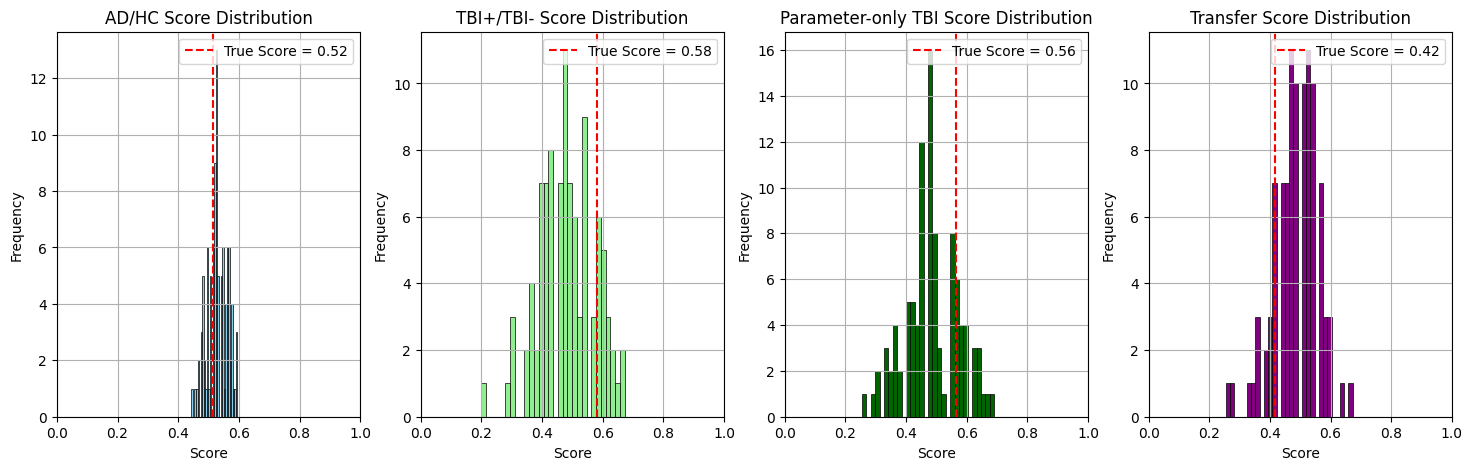

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex='all', squeeze=True)

# AD Score
axes[0].hist(perm_df["AD Score"], bins=30, color='skyblue', edgecolor='black', linewidth=0.5)
axes[0].axvline(score_ad, color='red', linestyle='--', label=f"True Score = {score_ad:.2f}")
axes[0].set_title("AD/HC Score Distribution")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(0,1)
axes[0].grid(True)
axes[0].legend()

# TBI Score
axes[1].hist(perm_df["TBI Score"], bins=30, color='lightgreen', edgecolor='black', linewidth=0.5)
axes[1].axvline(score_tbi, color='red', linestyle='--', label=f"True Score = {score_tbi:.2f}")
axes[1].set_title("TBI+/TBI- Score Distribution")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0,1)
axes[1].grid(True)
axes[1].legend()

# Parameter-only TBI Score
axes[2].hist(perm_df["AD Param-only Score"], bins=30, color='darkgreen', edgecolor='black', linewidth=0.5)
axes[2].axvline(score_param_tbi, color='red', linestyle='--', label=f"True Score = {score_param_tbi:.2f}")
axes[2].set_title("Parameter-only TBI Score Distribution")
axes[2].set_xlabel("Score")
axes[2].set_ylabel("Frequency")
axes[2].set_xlim(0,1)
axes[2].grid(True)
axes[2].legend()

# Transfer Score
# axes[3].hist(perm_df["Transfer Score"], bins=30, color='plum', edgecolor='black')
# axes[3].axvline(score_transfer, color='red', linestyle='--', label=f"True Score = {score_transfer:.2f}")
# axes[3].set_title("Transfer Score Distribution")
# axes[3].set_xlabel("Score")
# axes[3].set_ylabel("Frequency")
# axes[3].set_xlim(0,1)
# axes[3].grid(True)
# axes[3].legend()

# Transfer Scaled Score
axes[3].hist(perm_df["Scaled Transfer Score"], bins=30, color='purple', edgecolor='black', linewidth=0.5)
axes[3].axvline(score_transfer_scaled, color='red', linestyle='--', label=f"True Score = {score_transfer_scaled:.2f}")
axes[3].set_title("Transfer Score Distribution")
axes[3].set_xlabel("Score")
axes[3].set_ylabel("Frequency")
axes[3].set_xlim(0,1)
axes[3].grid(True)
axes[3].legend()

#plt.tight_layout()
plt.show()


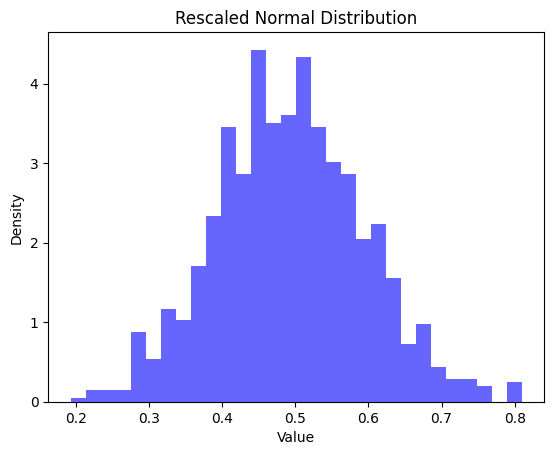

In [9]:
# Generate a normal distribution
samples = np.random.normal(loc=0.5, scale=0.1, size=1000)

# Rescale to fit the range [0.1, 0.9]
samples = np.clip(samples, 0.1, 0.9)

# Plot the results
plt.hist(samples, bins=30, density=True, alpha=0.6, color='b')
plt.title("Rescaled Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()